In [31]:
import numpy as np
import pandas as pd
import ast
import statsmodels.api as sm
import sqlite3
import datetime

# next command ensures that plots appear inside the notebook
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.colors
mpl.lines
import seaborn as sns  # also improves the look of plots
sns.set()
plt.rcParams['figure.figsize'] = 10, 5  # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1  # to fix issue with seaborn box plots; needed after import seaborn

In [32]:
#Opening the KLM sentiment CSV and doing some preprocessing
klm_sentiment = pd.read_csv('Full datasets/Sentiment all airlines/KLMSent.csv', encoding='utf-16').dropna(thresh=5)

klm_sentiment['created_at'] = klm_sentiment['created_at'].astype(str)
klm_sentiment = klm_sentiment.sort_values(['created_at']).reset_index()
klm_sentiment['user.id_str'] = klm_sentiment['user.id_str'].astype(str)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
#Convert the created_at data to timestamp objects
klm_sentiment['created_at'] = pd.to_datetime(klm_sentiment['created_at'], errors='coerce')

#Extracting the seperate timestamp objects and adding them to new columns in the dataframe
klm_sentiment['weekday'] = klm_sentiment['created_at'].dt.weekday
klm_sentiment['hour'] = klm_sentiment['created_at'].dt.hour
klm_sentiment['month'] = klm_sentiment['created_at'].dt.month
klm_sentiment['year'] = klm_sentiment['created_at'].dt.year
klm_sentiment['day'] = klm_sentiment['created_at'].dt.day

#Drop Nas in the day and month rows
klm_sentiment = klm_sentiment.dropna(subset=['day', 'month'])

#Making sure the months and days appear as integers in the matrix (not floats)
klm_sentiment = klm_sentiment.astype({'day':int, 'month':int})

klm_sentiment.head()

,index,Unnamed: 0,created_at,favorite_count,filter_level,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,...,user.id_str,entities,quoted_status,twee,sentiment,weekday,hour,month,year,day
77,26993,1425900,2016-08-05 00:02:05,0.0,low,7.613515e+17,7.613515318368911e+17,all_airlines,NaN,NaN,...,152171672.0,"{ ""hashtags"" : [ { ""text"" : ""AirlineComplaints...",NaN,KLM,0.0,4.0,0.0,8,2016.0,5
78,178203,1425914,2016-08-05 00:04:17,0.0,low,7.613521e+17,7.613520884460544e+17,KLM,7.613511e+17,7.613511e+17,...,230234820.0,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,KLM,0.0,4.0,0.0,8,2016.0,5
79,26994,1425939,2016-08-05 00:06:28,0.0,low,7.613526e+17,7.613526350058004e+17,NaN,NaN,NaN,...,993520008.0,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,klm,0.0,4.0,0.0,8,2016.0,5
80,26995,1425945,2016-08-05 00:07:31,0.0,low,7.613529e+17,7.613529018392207e+17,KLM,NaN,NaN,...,841745401.0,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,KLM,1.0,4.0,0.0,8,2016.0,5
81,178204,1426016,2016-08-05 00:14:12,0.0,low,7.613546e+17,7.613545849420759e+17,NaN,NaN,NaN,...,7.26875936042e+17,"{ ""hashtags"" : [ { ""text"" : ""Grotebazen"", ""ind...",NaN,KLM,0.0,4.0,0.0,8,2016.0,5


In [34]:
klm_grouped_sent = klm_sentiment.groupby(['month', 'day'])['sentiment'].mean().reset_index()

klm_sent_matrix = klm_grouped_sent.pivot('month', 'day', 'sentiment')
klm_sent_matrix

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
month,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.081531,-0.134181,-0.091127,-0.058504,0.119829
2,-0.054306,0.057872,0.085892,0.183452,-0.024126,0.113518,0.153466,0.107853,0.116765,0.014190,...,0.029719,-0.077762,-0.015219,0.330902,0.057907,0.173196,0.234568,NaN,NaN,NaN
3,0.072775,0.211409,0.207575,0.079570,0.051787,-0.015131,0.151895,-0.003133,0.071350,0.077862,...,-0.034893,0.010434,0.104623,0.042401,0.053058,0.019564,-0.149986,-0.023646,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.054922,0.054695
6,0.011509,0.031189,0.061180,0.080248,-0.006229,0.030454,0.009524,0.007539,0.136616,0.036283,...,0.258122,0.031135,-0.026572,0.021933,-0.186928,0.138616,0.026906,0.040022,0.056741,NaN
7,0.080246,-0.061128,-0.015888,0.147014,0.081827,0.192568,-0.006670,-0.030055,0.239362,0.114952,...,0.085077,-0.042245,-0.061580,0.044536,-0.163612,0.052242,0.293695,-0.047566,-0.013803,0.009637
8,-0.069120,-0.131291,-0.081328,-0.017308,0.088731,0.069387,0.147426,-0.052883,0.080212,0.091528,...,0.016266,0.111358,0.245920,0.154384,0.091058,0.150898,0.051620,0.065154,0.008915,0.166721
9,0.075009,0.086513,0.157502,0.023426,0.046730,0.021556,-0.027128,0.042565,0.003352,0.085207,...,0.141178,-0.027936,-0.006572,0.025228,0.318149,0.210861,0.455420,0.368375,0.207747,NaN
10,0.295562,0.358198,0.430349,0.151004,0.207421,0.070224,0.120101,0.226631,0.098439,0.155716,...,0.406718,0.256806,0.414360,0.082874,0.091691,0.172605,0.204854,0.205567,-0.046283,0.307398


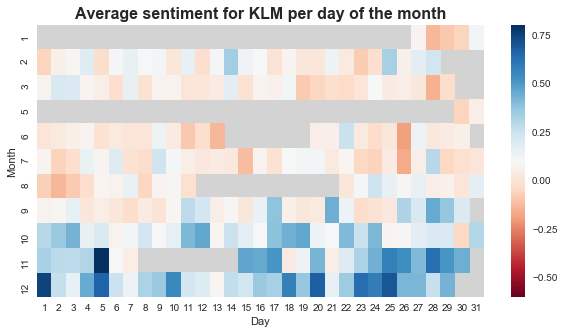

In [51]:
a = 0.3 * -1

#Creating a heatmap with the average sentiment per day of the month for KLM
ax_1 = sns.heatmap(klm_sent_matrix, cmap='RdBu', vmin=-0.3, vmax=0.8, center=0.1)
ax_1.set_title('Average sentiment for KLM per day of the month', size=16, weight='bold')
ax_1.set_ylabel('Month')
ax_1.set_xlabel('Day')
ax_1.set_facecolor('lightgrey');

In [52]:
ax_1.get_figure().savefig('Sentiment heatmap KLM reverse.png')

In [18]:
ba_sentiment = pd.read_csv('Full datasets/Sentiment all airlines/BASent.csv', encoding='utf-16').dropna(thresh=5)

ba_sentiment['created_at'] = ba_sentiment['created_at'].astype(str)
ba_sentiment = ba_sentiment.sort_values(['created_at']).reset_index()
ba_sentiment['user.id_str'] = ba_sentiment['user.id_str'].astype(str)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1,3,4,5,6,11,14,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
#Convert the created_at data to timestamp objects
ba_sentiment['created_at'] = pd.to_datetime(ba_sentiment['created_at'], errors='coerce')

#Extracting the seperate timestamp objects and adding them to new columns in the dataframe
ba_sentiment['weekday'] = ba_sentiment['created_at'].dt.weekday
ba_sentiment['hour'] = ba_sentiment['created_at'].dt.hour
ba_sentiment['month'] = ba_sentiment['created_at'].dt.month
ba_sentiment['year'] = ba_sentiment['created_at'].dt.year
ba_sentiment['day'] = ba_sentiment['created_at'].dt.day

#Drop Nas in the day and month rows
ba_sentiment = ba_sentiment.dropna(subset=['day', 'month'])

#Making sure the months and days appear as integers in the matrix (not floats)
ba_sentiment = ba_sentiment.astype({'day':int, 'month':int})

ba_sentiment.head()

,index,Unnamed: 0,created_at,favorite_count,filter_level,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,...,user.id_str,entities,quoted_status,twee,sentiment,weekday,hour,month,year,day
56,117152,1425873,2016-08-05 00:00:52,0.0,low,7.61351e+17,7.61351227074605e+17,TeamGB,7.600284e+17,7.600284e+17,...,14040872.0,"{ ""hashtags"" : [ { ""text"" : ""PlaneyMcPlaneFace...",NaN,British_Airways,0.0,4.0,0.0,8,2016.0,5
57,117153,1425878,2016-08-05 00:01:03,0.0,low,7.61351e+17,7.613512746505585e+17,British_Airways,NaN,NaN,...,234964911.0,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,British_Airways,0.0,4.0,0.0,8,2016.0,5
58,117154,1425882,2016-08-05 00:01:21,0.0,low,7.61351e+17,7.613513509113733e+17,British_Airways,NaN,NaN,...,234964911.0,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,British_Airways,0.0,4.0,0.0,8,2016.0,5
59,117155,1425908,2016-08-05 00:03:28,0.0,low,7.61352e+17,7.613518825392742e+17,NaN,NaN,NaN,...,30768897.0,"{ ""hashtags"" : [ { ""text"" : ""Brooklyn"", ""indic...",NaN,British_Airways,1.0,4.0,0.0,8,2016.0,5
60,117156,1425933,2016-08-05 00:05:57,0.0,low,7.61353e+17,7.613525061443338e+17,British_Airways,NaN,NaN,...,454091410.0,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,British_Airways,-1.0,4.0,0.0,8,2016.0,5


In [20]:
ba_grouped_sent = ba_sentiment.groupby(['month', 'day'])['sentiment'].mean().reset_index()

ba_sent_matrix = ba_grouped_sent.pivot('month', 'day', 'sentiment')
ba_sent_matrix

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
month,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.006131,0.029037,0.027817,0.096680,0.110438
2,0.027195,0.063146,0.067082,0.086772,0.087646,0.020271,0.177086,0.142851,0.116248,-0.015813,...,-0.045929,-0.031354,0.003711,0.120362,-0.000110,0.018177,0.040841,NaN,NaN,NaN
3,0.052066,0.045507,0.083118,0.031859,-0.078453,0.003780,0.037172,0.158577,-0.020414,-0.014772,...,0.048328,0.031212,0.108911,0.041614,-0.017950,-0.002404,0.090679,0.111874,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.041667,0.052274
6,-0.049436,0.380957,0.177871,0.099680,0.196528,-0.030207,-0.274048,-0.033984,-0.267540,-0.121349,...,-0.095598,-0.165506,-0.163974,-0.113902,-0.145582,-0.110469,-0.029776,-0.019131,-0.025470,NaN
7,-0.118724,-0.148228,-0.015281,-0.007702,-0.061125,-0.089615,-0.029534,-0.046115,-0.030893,-0.093949,...,-0.072680,-0.250045,-0.205126,-0.036675,0.056124,0.053703,-0.044235,0.003967,-0.024139,-0.127208
8,-0.033923,-0.041634,-0.049804,-0.022279,0.078833,-0.065241,-0.018826,0.017780,0.042279,0.016564,...,0.107972,0.247094,0.121291,0.048732,0.068983,-0.044192,-0.037280,-0.090936,-0.746674,-0.677741
9,-0.603251,-0.359031,-0.267283,-0.316920,-0.252595,-0.238948,-0.039840,-0.098243,-0.111757,-0.209863,...,-0.002362,0.030383,-0.023390,-0.032155,0.060116,-0.000592,-0.007356,0.083151,0.057890,NaN
10,0.024517,-0.031907,0.033474,-0.015203,0.091588,-0.013220,0.092965,0.070501,0.012958,0.041687,...,0.029111,0.008945,-0.001695,0.078995,0.307877,0.115091,0.076904,0.012004,0.067999,-0.005471


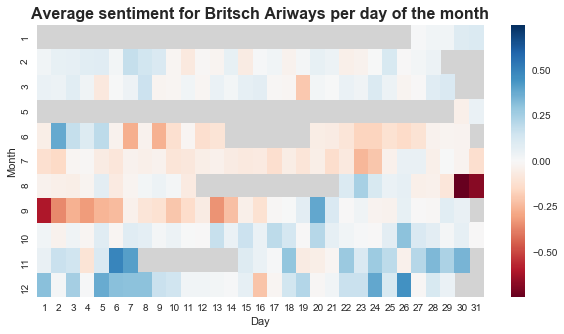

In [22]:
ax_2 = sns.heatmap(ba_sent_matrix, cmap='RdBu')
ax_2.set_title('Average sentiment for Britsch Ariways per day of the month', size=16, weight='bold')
ax_2.set_ylabel('Month')
ax_2.set_xlabel('Day')
ax_2.set_facecolor('lightgrey');